# Delitos Municipales y su Impacto en la Gestión de Seguros con Enfoque en Análisis de Datos
______________________________

## Introducción

En este análisis, se explora una base de datos de delitos municipales proporcionada por el gobierno de México en https://datos.gob.mx/busca/dataset/incidencia-delictiva-del-fuero-comun-a-nivel-municipal con el objetivo de comprender patrones delictivos y su impacto en la evaluación de riesgos para compañías de seguros.

La incidencia delictiva es un factor clave en la determinación del riesgo de las pólizas de seguro, ya que un mayor índice de delitos en una región puede influir en las primas y en la viabilidad de ciertos productos aseguradores. A través de un análisis estructurado, este proyecto busca proporcionar información valiosa que permita a las aseguradoras tomar decisiones fundamentadas sobre la asignación de riesgos y estrategias de cobertura.

El estudio abarca desde la carga y limpieza de los datos hasta su análisis mediante modelos de series de tiempo y técnicas de clustering. Finalmente, los resultados se presentan en un tablero interactivo de Google Data Studio, facilitando la visualización de hallazgos y la toma de decisiones basada en datos.


________________________
## Setup

Se descargan algunas de las librerías necesarias para llevar a cabo el proyecto

In [ ]:
import chardet
import pandas as pd
import os
import plotly.express as px
import matplotlib.pyplot as plt
import pymssql
import seaborn as sns

__________________________
## Descarga y Creación de la Base de Datos

###  Proceso de descarga de los datos desde la página oficial de datos abiertos.


Dentro del archivo Zip descargable en la página del gobierno de México se encuentra la información de los delitos cometidos en el país desde 2015 hasta 2021.
Podemos encontrar un archivo de xml por cada año y un archivo csv donde se hace la recoplilación de los 6 años.
En este caso se hará una lectura del archivo csv para hacer un análisis más completo de la información disponible.

In [ ]:
# Lectura de una muestra del archivo para detectar la codificación
with open('C:/Users/estef/Desktop/data/Municipal-Delitos-2015-2021_dic2021.csv', 'rb') as f:
    result = chardet.detect(f.read(10000))  # Se leen los primeros 10,000 bytes
    print(result)

Se detectó un formato de codificación diferente a utf-8 por lo que se genera uno nuevo con el formato mencionado

In [ ]:
# Lectura del archivo CSV con la codificación detectada
df = pd.read_csv('C:/Users/estef/Desktop/data/Municipal-Delitos-2015-2021_dic2021.csv', encoding='latin1')  

# Creación del archivo con codificación UTF-8
df.to_csv('C:/Users/estef/Desktop/data/Municipal-Delitos-2015-2021_dic2021_utf8.csv', index=False, encoding='utf-8')

In [ ]:
#Lectura y visualización del archivo
os.chdir('C:/Users/estef/Desktop/data')
df = pd.read_csv('Municipal-Delitos-2015-2021_dic2021_utf8.csv')
df.sample(5)

###  Creación de la base de datos en SQL.

Se crea en SQL una base de datos donde se insertará la tabla con la información del proyecto con:
- CREATE DATABASE Delitos1521;


## Conexión a la Base de Datos desde Python

In [ ]:
import pyodbc
from sqlalchemy import create_engine
from sqlalchemy import text

# Parámetros de conexión
server = 'LAPTOP-DBH59CJ0'
database = 'Delitos1521'
driver = 'ODBC Driver 17 for SQL Server' 

# Se crea conexión con SQLAlchemy
engine = create_engine(f"mssql+pyodbc://{server}/{database}?trusted_connection=yes&driver={driver}&database={database}")
# Se guarda el DataFrame en SQL Server
df.to_sql('Delitos1521', con=engine, schema='dbo', if_exists='replace', index=False)
print("Datos insertados correctamente en SQL Server.")

In [ ]:
# Comprobar que la conexión se realizó con la base de datos correcta
with engine.connect() as conn:
    result = conn.execute(text("SELECT DB_NAME()"))
    print("Conectado a la base de datos:", result.fetchone()[0])

In [ ]:
# Comprobar información de la tabla y esquema donde se creo
with engine.connect() as conn:
    result = conn.execute(text("SELECT TABLE_SCHEMA, TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_NAME = 'Delitos1521'"))
    tables = result.fetchall()
    print("Tablas encontradas:", tables)

In [ ]:
# Comprobar información contenida en la tabla
with engine.connect() as conn:
    result = conn.execute(text("SELECT COUNT(*) FROM dbo.Delitos1521"))
    print("Número de filas en la tabla:", result.fetchone()[0])

## Limpieza y Transformación de los Datos

In [ ]:
# Se verifican los tipos de datos que contiene la tabla, no se presentan nulos 
df.info()

In [ ]:
# Datos únicos por columna
df.nunique()

In [ ]:
df.columns

Encontrar y filtrar delitos que esten relacionados con automoviles

In [ ]:
#Bien jurídico afectado (No se identifican categorías directamente relacionadas con automóviles)
print('Bien jurídico afectado')
print(df['Bien jurídico afectado'].unique().__len__())
print(df['Bien jurídico afectado'].sort_values().unique())

In [ ]:
#Tipo de delito (No se identifican categorías directamente relacionadas con automóviles)
print('Tipo de delito')
print(df['Tipo de delito'].unique().__len__())
print(df['Tipo de delito'].sort_values().unique())

In [ ]:
#Subtipo de delito (Se identifican delitos relacionados a atomóviles)
print('Subtipo de delito')
print(df['Subtipo de delito'].unique().__len__())
print(df['Subtipo de delito'].sort_values().unique())
#'Robo a transportista','Robo de autopartes', 'Robo de maquinaria','Robo de vehículo automotor', 
# 'Robo en transporte individual','Robo en transporte público colectivo', 'Robo en transporte público individual'
# Resumen de palabras: transportista, autopartes, maquinaria, vehículo, transporte

In [ ]:
#Modalidad (Se identifican delitos relacionados a atomóviles)
print('Modalidad')
print(df['Modalidad'].unique().__len__())
print(df['Modalidad'].sort_values().unique().tolist())

#'En accidente de tránsito'l,'Robo de coche de 4 ruedas Con violencia', 'Robo de coche de 4 ruedas Sin violencia',
# 'Robo de motocicleta Con violencia', 'Robo de motocicleta Sin violencia', 'Robo de tractores Con violencia', 'Robo de tractores Sin violencia'
#Resumen de palabras: tránsito, coche, motocicleta, tractores 

Se crea un nuevo df que únicamente contenga delitos relacionados con automóviles

In [ ]:
#Crear copia de base de datos original para crear una nueva con información solo relacionada a automóviles
delitos_autos = df.copy()
#Crear columna adicional con toda la información del delito
delitos_autos["Delito"] = delitos_autos[['Tipo de delito', 'Subtipo de delito', 'Modalidad']].agg('-'.join, axis=1)
delitos_autos.sample(5)

In [ ]:
#Filtrar para que solo contenga delitos relacionados con autos con las palabras identificadas
#palabras relacionadas: transportista, autopartes, maquinaria, vehículo, transporte, tránsito, coche, motocicleta, tractores 
delitos_autos = delitos_autos[delitos_autos['Delito'].str.contains('transportista|autopartes|vehículo|transporte|tránsito|coche|motocicleta|tractores|transito')]
delitos_autos

In [18]:
#Comprobar que solo queden delitos relacionados con automóviles
print('Delito')
print(delitos_autos['Delito'].unique().__len__())
print(delitos_autos['Delito'].sort_values().unique())

Delito
20
['Homicidio-Homicidio culposo-En accidente de tránsito'
 'Lesiones-Lesiones culposas-En accidente de tránsito'
 'Robo-Robo a transportista-Con violencia'
 'Robo-Robo a transportista-Sin violencia'
 'Robo-Robo de autopartes-Con violencia'
 'Robo-Robo de autopartes-Sin violencia'
 'Robo-Robo de maquinaria-Robo de tractores Con violencia'
 'Robo-Robo de maquinaria-Robo de tractores Sin violencia'
 'Robo-Robo de vehículo automotor-Robo de coche de 4 ruedas Con violencia'
 'Robo-Robo de vehículo automotor-Robo de coche de 4 ruedas Sin violencia'
 'Robo-Robo de vehículo automotor-Robo de embarcaciones pequeñas y grandes Con violencia'
 'Robo-Robo de vehículo automotor-Robo de embarcaciones pequeñas y grandes Sin violencia'
 'Robo-Robo de vehículo automotor-Robo de motocicleta Con violencia'
 'Robo-Robo de vehículo automotor-Robo de motocicleta Sin violencia'
 'Robo-Robo en transporte individual-Con violencia'
 'Robo-Robo en transporte individual-Sin violencia'
 'Robo-Robo en transp

In [19]:
#Filtrando los datos para que el df unicamente contenga delitos relacionados a automóviles 
# se redujo la cantidad de datos de 1,589,462 a 324,380 
delitos_autos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 324380 entries, 6 to 1589434
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Año                     324380 non-null  int64 
 1   Clave_Ent               324380 non-null  int64 
 2   Entidad                 324380 non-null  object
 3   Cve. Municipio          324380 non-null  int64 
 4   Municipio               324380 non-null  object
 5   Bien jurídico afectado  324380 non-null  object
 6   Tipo de delito          324380 non-null  object
 7   Subtipo de delito       324380 non-null  object
 8   Modalidad               324380 non-null  object
 9   Enero                   324380 non-null  int64 
 10  Febrero                 324380 non-null  int64 
 11  Marzo                   324380 non-null  int64 
 12  Abril                   324380 non-null  int64 
 13  Mayo                    324380 non-null  int64 
 14  Junio                   324380 non-null 

## Análisis de Series de Tiempo

Objetivo: Identificar patrones y tendencias en los delitos de 2015 a 2021 y predecir los delitos en 2022.

Selección y de un Municipio para su análisis.

Visualización de Datos: Incluye los gráficos del tablero de locker studio enfocados en esta parte.

Predicciones: Explica el modelo de series de tiempo elegido, muestra las predicciones para 2022 e incluye gráficos comparativos.

In [21]:
#Crear columna 'Total_Delitos' que muestre la cantidad de incidencias cometidads por delito por año
delitos_autos['Total_Delitos'] = delitos_autos[['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']].sum(axis=1)
delitos_autos.sample(5)

,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Enero,...,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre,Delito,Total_Delitos
242200,2016,14,Jalisco,14009,El Arenal,El patrimonio,Robo,Robo de vehículo automotor,Robo de coche de 4 ruedas Sin violencia,1,...,0,1,1,0,2,0,2,0,Robo-Robo de vehículo automotor-Robo de coche ...,19
1400756,2021,14,Jalisco,14012,Atenguillo,El patrimonio,Robo,Robo de vehículo automotor,Robo de coche de 4 ruedas Sin violencia,0,...,0,0,0,0,0,0,0,0,Robo-Robo de vehículo automotor-Robo de coche ...,0
383631,2017,5,Coahuila de Zaragoza,5021,Nadadores,El patrimonio,Robo,Robo en transporte individual,Con violencia,0,...,0,0,0,0,0,0,0,0,Robo-Robo en transporte individual-Con violencia,0
22975,2015,8,Chihuahua,8037,Juárez,El patrimonio,Robo,Robo de vehículo automotor,Robo de motocicleta Con violencia,1,...,2,0,0,1,0,0,0,0,Robo-Robo de vehículo automotor-Robo de motoci...,8
925275,2019,14,Jalisco,14106,Tuxcacuesco,El patrimonio,Robo,Robo en transporte público colectivo,Con violencia,0,...,0,0,0,0,0,0,0,0,Robo-Robo en transporte público colectivo-Con ...,0


In [22]:
#Calcular promedio de delitos cometidos por mes por año
delitos_autos_mensual = delitos_autos.groupby('Año')[['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']].mean()
delitos_autos_mensual

,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre
Año,,,,,,,,,,,,
2015,0.533635,0.510772,0.547747,0.502356,0.524236,0.522760,0.522553,0.530347,0.525971,0.534801,0.551476,0.537985
2016,0.477317,0.495262,0.514397,0.501269,0.520016,0.508286,0.519161,0.543086,0.578509,0.590653,0.597437,0.614940
2017,0.497932,0.461922,0.512328,0.476784,0.519647,0.512328,0.523986,0.552149,0.529643,0.568512,0.546107,0.519505
2018,0.556151,0.515419,0.555787,0.532902,0.556920,0.505140,0.527924,0.557608,0.511271,0.565480,0.555989,0.543464
2019,0.542007,0.493727,0.536908,0.496014,0.527438,0.492594,0.503946,0.491016,0.472218,0.497369,0.477297,0.460987
2020,0.472764,0.443039,0.448219,0.341643,0.337718,0.364873,0.390166,0.391623,0.387718,0.417098,0.399798,0.399130
2021,0.380912,0.366384,0.416868,0.399374,0.413136,0.413015,0.419189,0.417252,0.416162,0.442817,0.430730,0.435956


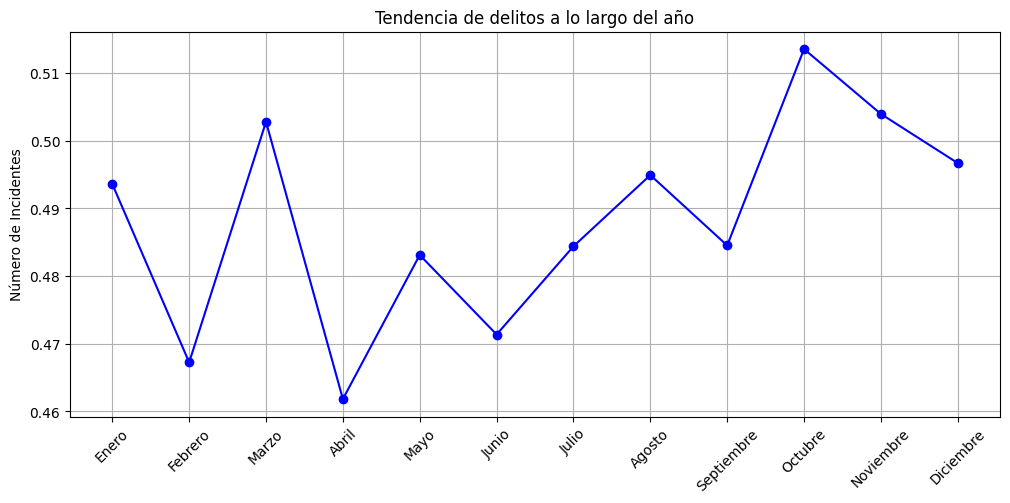

In [24]:
delitos_autos_mensual = delitos_autos.iloc[:, 9:21].mean()

plt.figure(figsize=(12,5))
plt.plot(delitos_autos_mensual.index, delitos_autos_mensual.values, marker='o', linestyle='-', color='b')
plt.xticks(rotation=45)
plt.title('Tendencia de delitos a lo largo del año')
plt.ylabel('Número de Incidentes')
plt.grid(True)
plt.show()

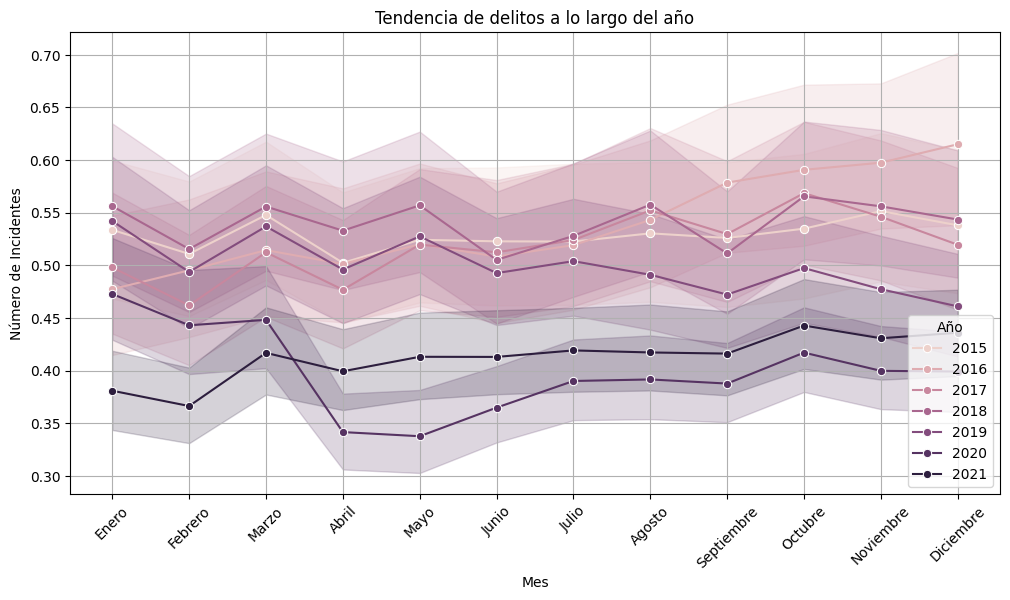

In [25]:
#Gráfica de promedio de delitos cometidos mensualmente por cada año del DF
# Seleccionar solo las columnas de meses y el año
delitos_autos_mensual = delitos_autos.melt(id_vars=['Año'], 
                                           value_vars=delitos_autos.columns[9:21], 
                                           var_name='Mes', value_name='Incidentes')

# Ordenar los meses en el orden correcto
orden_meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 
               'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
delitos_autos_mensual['Mes'] = pd.Categorical(delitos_autos_mensual['Mes'], categories=orden_meses, ordered=True)

# Graficar con seaborn
plt.figure(figsize=(12,6))
sns.lineplot(data=delitos_autos_mensual, x='Mes', y='Incidentes', hue='Año', marker='o')

# Estilo del gráfico
plt.xticks(rotation=45)
plt.title('Tendencia de delitos a lo largo del año')
plt.ylabel('Número de Incidentes')
plt.xlabel('Mes')
plt.grid(True)
plt.legend(title='Año')

plt.show()

### Selección del Municipio

In [30]:
# Sumar el total de delitos por municipio
municipios_totales = delitos_autos.groupby("Municipio")[delitos_autos.columns[9:21]].mean()
municipios_totales["Total_Delitos"] = municipios_totales.sum(axis=1)

# Mostrar los 10 municipios con más delitos
municipios_totales.sort_values("Total_Delitos", ascending=False).head(10)

,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre,Total_Delitos
Municipio,,,,,,,,,,,,,
Ecatepec de Morelos,52.171429,50.971429,55.578571,51.235714,57.492857,53.514286,53.978571,55.792857,53.521429,57.164286,57.371429,53.721429,652.514286
Guadalajara,33.935714,33.585714,33.350000,29.592857,32.685714,36.814286,38.950000,40.507143,35.721429,38.685714,36.350000,33.864286,424.042857
Tijuana,37.592857,33.371429,35.271429,32.885714,33.521429,31.028571,32.064286,33.135714,33.114286,33.721429,34.128571,38.150000,407.985714
Tlalnepantla de Baz,25.292857,24.292857,27.200000,25.228571,27.114286,25.407143,26.450000,26.857143,26.957143,27.957143,27.550000,24.878571,315.185714
Toluca,24.335714,23.214286,24.407143,23.914286,23.928571,21.992857,23.928571,25.335714,25.171429,25.907143,25.471429,25.292857,292.900000
Naucalpan de Juárez,22.100000,21.521429,23.328571,22.392857,23.942857,21.764286,22.128571,23.250000,23.464286,24.385714,23.357143,23.121429,274.757143
Puebla,21.114286,19.950000,21.557143,21.150000,22.050000,20.528571,21.607143,20.485714,20.207143,21.200000,20.864286,20.592857,251.307143
Iztapalapa,21.114286,19.892857,20.864286,18.900000,19.971429,19.242857,18.807143,19.828571,19.257143,21.621429,21.192857,20.585714,241.278571
Querétaro,17.978571,17.150000,18.778571,17.407143,18.164286,19.035714,20.492857,21.250000,19.550000,20.578571,19.321429,19.521429,229.228571


Debido a que es uno de los municipios con mayor incidencia de delitos relacionados con automóviles, se selecciona a Guadalajara para hacer los siguientes análisis

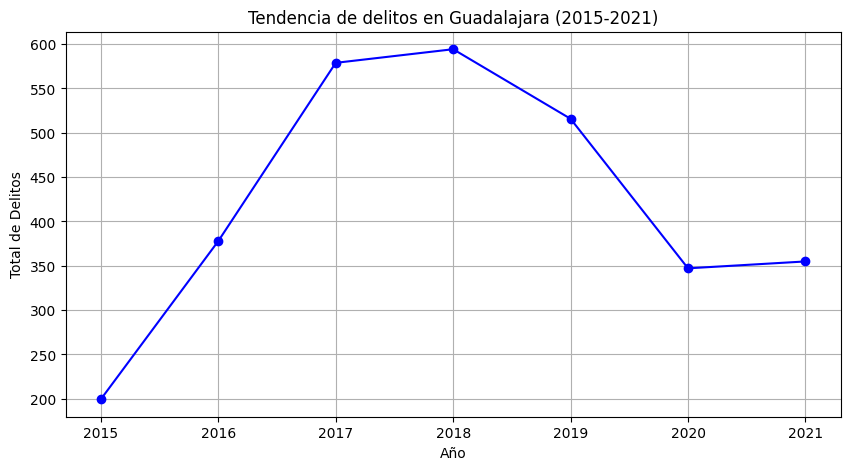

In [27]:
# Seleccionar municipio
gdl = "Guadalajara"

# Sumar delitos por año en el municipio seleccionado
delitos_gdl = delitos_autos[delitos_autos["Municipio"] == gdl].groupby("Año")[delitos_autos.columns[9:21]].mean()
delitos_gdl["Total_Delitos"] = delitos_gdl.sum(axis=1)

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(delitos_gdl.index, delitos_gdl["Total_Delitos"], marker="o", linestyle="-", color="b")
plt.title(f"Tendencia de delitos en {gdl} (2015-2021)")
plt.xlabel("Año")
plt.ylabel("Total de Delitos")
plt.grid(True)
plt.show()

## Clasificación de Estados por Peligrosidad (Clustering)

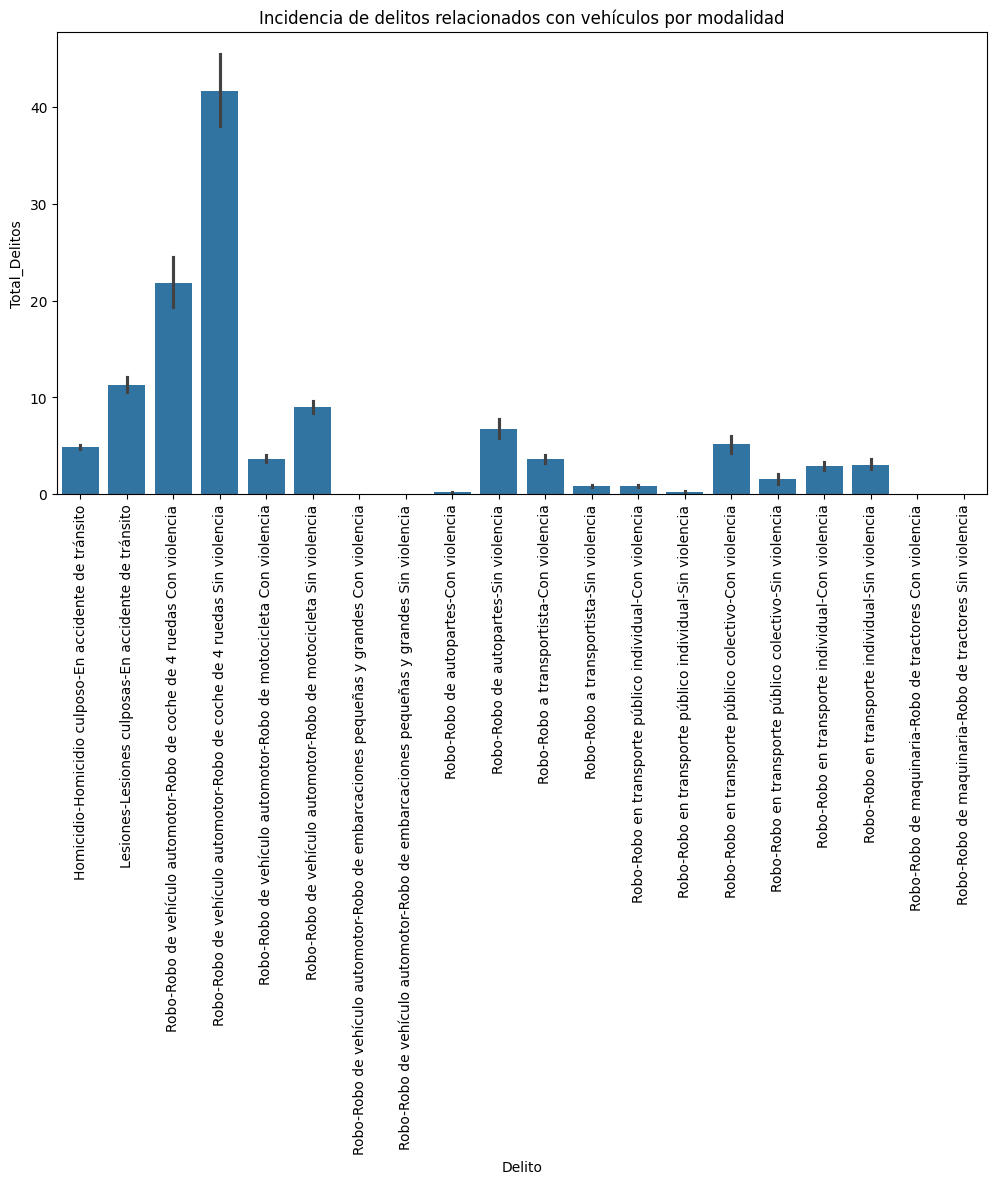

In [31]:
# Delitos relacionados con vehículos por modalidad
plt.figure(figsize=(12,6))
sns.barplot(data=delitos_autos, x='Delito', y='Total_Delitos')
plt.xticks(rotation=90)
plt.title('Incidencia de delitos relacionados con vehículos por modalidad')
plt.show()

Para la siguiente visualización se utilizará un Shape file por lo que primero se hará la carga del archivo obtenido de http://geoportal.conabio.gob.mx/metadatos/doc/html/mun21gw.html

In [32]:
#!pip install geopandas
import geopandas as gpd

# Cargar el shapefile
municipios = gpd.read_file("D:\data\SF Municipios2\mun21gw.shp")

# Mostrar los primeros registros
print(municipios.head())

  CVEGEO CVE_ENT CVE_MUN         NOM_ENT  COV_  COV_ID         AREA  \
0  01008      01     008  Aguascalientes     0       1   857.790574   
1  01009      01     009  Aguascalientes     1       2   229.661012   
2  01010      01     010  Aguascalientes     2       3   504.050989   
3  01011      01     011  Aguascalientes     3       4   137.770176   
4  01001      01     001  Aguascalientes     4       5  1166.359248   

       PERIMETER                    NOM_MUN  \
0  181537.599568        San JosÃ© de Gracia   
1   89329.531706                  TepezalÃ¡   
2  144866.490027                   El Llano   
3  103689.065529  San Francisco de los Romo   
4  256631.025247             Aguascalientes   

                                            geometry  
0  POLYGON ((-102.35385 22.12064, -102.35426 22.1...  
1  POLYGON ((-102.16213 22.34851, -102.16149 22.3...  
2  POLYGON ((-101.89778 21.95839, -101.89037 21.9...  
3  POLYGON ((-102.14088 22.07534, -102.14086 22.0...  
4  POLYGON ((-1

In [33]:
# Delitos por municipio por mes
delitos_mapa = delitos_autos.groupby("Municipio")[delitos_autos.columns[9:21]].sum().reset_index()
delitos_mapa

,Municipio,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre
0,Abalá,0,0,0,0,0,0,0,0,1,0,0,0
1,Abasolo,39,45,63,43,61,46,24,40,37,39,43,30
2,Abejones,0,0,0,0,0,0,0,0,0,0,0,0
3,Acacoyagua,11,9,7,12,8,12,12,8,16,19,7,8
4,Acajete,78,78,69,94,61,49,59,86,69,47,72,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2326,Zumpahuacán,5,1,5,8,4,4,3,7,7,4,2,4
2327,Zumpango,635,592,554,548,532,514,522,562,552,612,563,580
2328,Álamo Temapache,47,67,61,50,86,56,62,63,75,51,71,62
2329,Álvaro Obregón,1199,1111,1251,1152,1180,1118,1145,1179,1171,1214,1239,1096


In [34]:
# Delitos por municipio 2015-2021
delitos_mapa["Total_Delitos"] = delitos_mapa.iloc[:, 1:].sum(axis=1)
print('Loa municipios con mayor incidencia de delitos relacionados con automóviles 2015-2021:')
delitos_mapa.sort_values('Total_Delitos').tail(10)

Loa municipios con mayor incidencia de delitos relacionados con automóviles 2015-2021:


,Municipio,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre,Total_Delitos
1161,Querétaro,2517,2401,2629,2437,2543,2665,2869,2975,2737,2881,2705,2733,32092
202,Benito Juárez,2761,2707,2967,2535,2696,2488,2702,2804,2474,2888,2846,2735,32603
739,Iztapalapa,2956,2785,2921,2646,2796,2694,2633,2776,2696,3027,2967,2882,33779
1140,Puebla,2956,2793,3018,2961,3087,2874,3025,2868,2829,2968,2921,2883,35183
1005,Naucalpan de Juárez,3094,3013,3266,3135,3352,3047,3098,3255,3285,3414,3270,3237,38466
2106,Toluca,3407,3250,3417,3348,3350,3079,3350,3547,3524,3627,3566,3541,41006
2073,Tlalnepantla de Baz,3541,3401,3808,3532,3796,3557,3703,3760,3774,3914,3857,3483,44126
2032,Tijuana,5263,4672,4938,4604,4693,4344,4489,4639,4636,4721,4778,5341,57118
594,Guadalajara,4751,4702,4669,4143,4576,5154,5453,5671,5001,5416,5089,4741,59366
509,Ecatepec de Morelos,7304,7136,7781,7173,8049,7492,7557,7811,7493,8003,8032,7521,91352


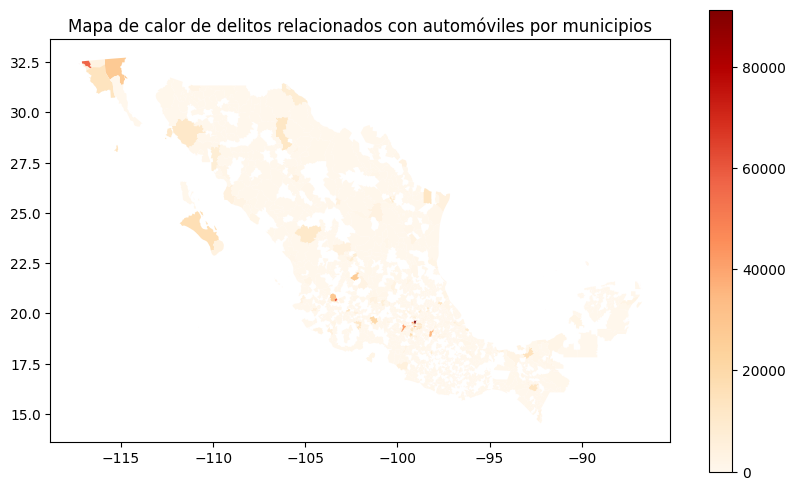

In [35]:
# Unir datos con el DataFrame de delitos
municipios = municipios.merge(delitos_mapa, left_on="NOM_MUN", right_on="Municipio")

# Graficar
municipios.plot(column="Total_Delitos", cmap="OrRd", legend=True, figsize=(10, 6))
plt.title("Mapa de calor de delitos relacionados con automóviles por municipios")
plt.show()


Agrupamiento de estados según su nivel de delitos, permitiendo ver qué estados tienen una criminalidad similar.

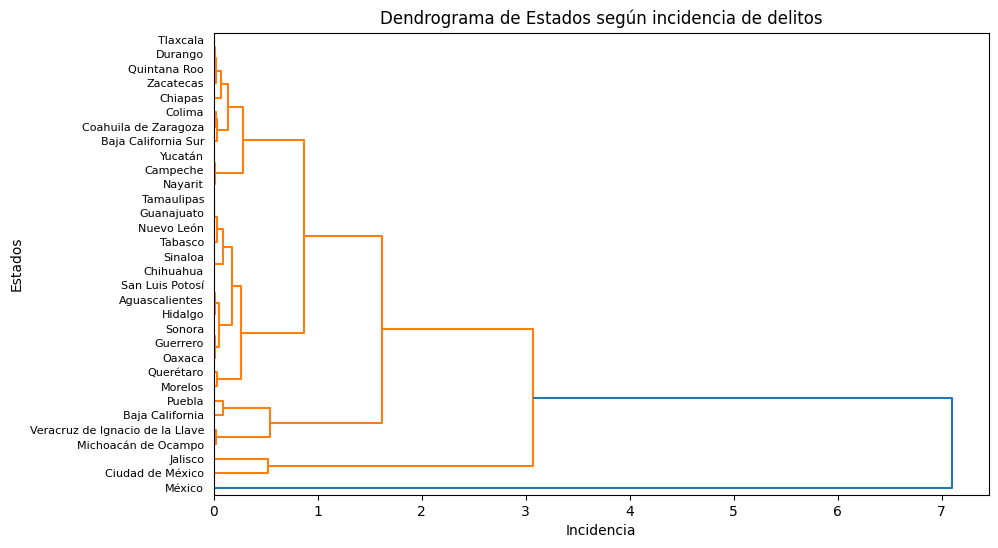

In [36]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

# Agrupar delitos por entidad
autos_cluster = delitos_autos.groupby('Entidad')[delitos_autos.columns[9:21]].sum()
autos_cluster["Total_Delitos"] = autos_cluster.sum(axis=1)

# Normalizar
scaler = StandardScaler()
autos_scaled = scaler.fit_transform(autos_cluster[['Total_Delitos']])

# clustering Jerárquico
linked = linkage(autos_scaled, method='ward')

# Graficar Dendrograma
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=autos_cluster.index, orientation='right')
plt.title("Dendrograma de Estados según incidencia de delitos")
plt.xlabel("Incidencia")
plt.ylabel("Estados")
plt.show()

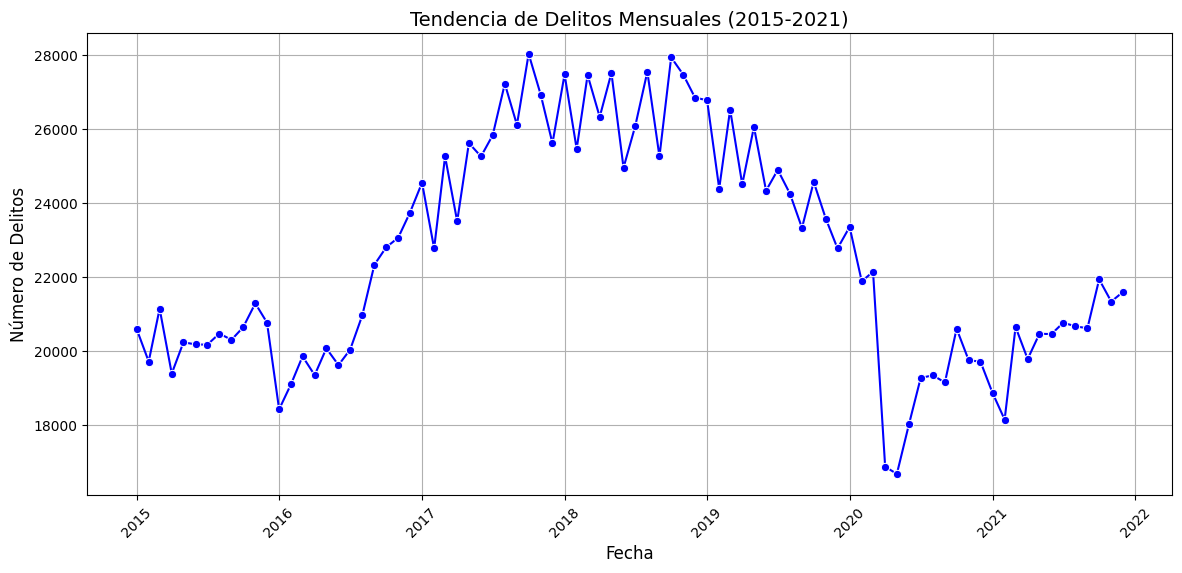

In [37]:
delitos_fechas=delitos_autos.copy()
delitos_fechas = delitos_fechas.drop('Total_Delitos', axis = 1)
# Convertir de formato ancho a largo (melt)
delitos_fechas = delitos_fechas.melt(id_vars=["Año"], 
                  value_vars=delitos_fechas.columns[9:21], 
                  var_name="Mes", 
                  value_name="Total_Delitos")

# Mapeo de los meses a valores numéricos
meses_orden = {'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4, 'Mayo': 5, 'Junio': 6,
               'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12}
delitos_fechas["Mes"] = delitos_fechas["Mes"].map(meses_orden)

# Crear una columna de fecha en formato YYYY-MM
delitos_fechas["Fecha"] = pd.to_datetime(delitos_fechas["Año"].astype(str) + "-" + delitos_fechas["Mes"].astype(str) + "-01")

# Agrupar por mes y sumar los delitos
delitos_grouped = delitos_fechas.groupby("Fecha")["Total_Delitos"].sum().reset_index()

# raficar la evolución de delitos a lo largo del tiempo
plt.figure(figsize=(14, 6))
sns.lineplot(data=delitos_grouped, x="Fecha", y="Total_Delitos", marker="o", color="b")

# Personalización de la gráfica
plt.title("Tendencia de Delitos Mensuales (2015-2021)", fontsize=14)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Número de Delitos", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [48]:
delitos_fechas.to_csv('delitos_fechas.csv', index=False)


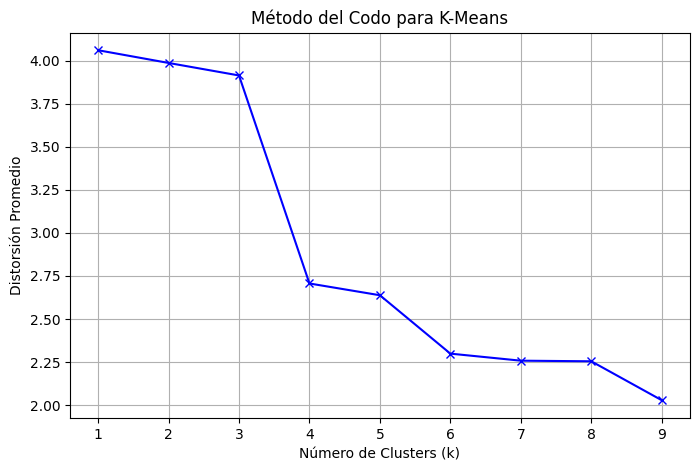

In [38]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# Eliminar columnas de fechas antes de aplicar KMeans
delitos_numericos = delitos_fechas.select_dtypes(include=['number'])

clusters = range(1, 10)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k, random_state=42) 
    model.fit(delitos_numericos)
    prediction = model.predict(delitos_numericos)
    meanDistortions.append(sum(np.min(cdist(delitos_numericos, model.cluster_centers_, 'euclidean'), axis=1)) / delitos_fechas.shape[0])

# Graficar curva de codo
plt.figure(figsize=(8, 5))
plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Distorsión Promedio')
plt.title('Método del Codo para K-Means')
plt.grid()
plt.show()

# Se identifica que un buen número de clusters en 4

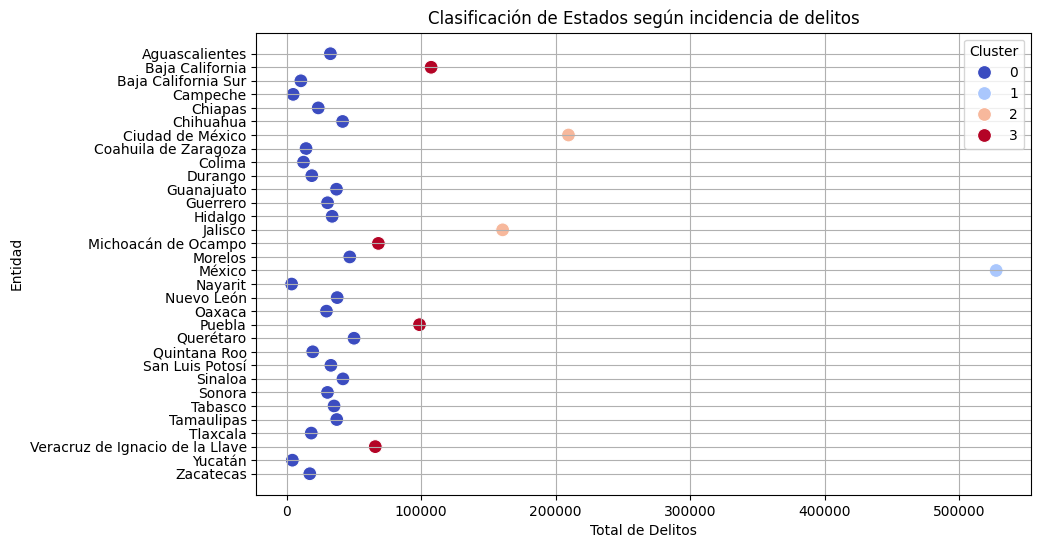

In [39]:

# Aplicar K-Means con 3 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
autos_cluster["Cluster"] = kmeans.fit_predict(autos_scaled)

# Graficar Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=autos_cluster, x='Total_Delitos', y=autos_cluster.index, hue="Cluster", palette="coolwarm", s=100)
plt.xlabel("Total de Delitos")
plt.ylabel("Entidad")
plt.title("Clasificación de Estados según incidencia de delitos")
plt.legend(title="Cluster")
plt.grid()
plt.show()

## Análisis Guadalajara

In [40]:
#Datos de Guadalajara
delitos_gdl = delitos_autos[delitos_autos['Municipio']=='Guadalajara']
delitos_gdl.sample(5)

,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Enero,...,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre,Delito,Total_Delitos
918710,2019,14,Jalisco,14039,Guadalajara,El patrimonio,Robo,Robo en transporte público colectivo,Sin violencia,0,...,0,0,0,0,0,0,0,0,Robo-Robo en transporte público colectivo-Sin ...,0
676550,2018,14,Jalisco,14039,Guadalajara,El patrimonio,Robo,Robo en transporte público individual,Sin violencia,0,...,0,0,0,0,0,0,0,0,Robo-Robo en transporte público individual-Sin...,0
55919,2015,14,Jalisco,14039,Guadalajara,El patrimonio,Robo,Robo en transporte individual,Con violencia,0,...,0,0,0,0,0,0,0,0,Robo-Robo en transporte individual-Con violencia,0
245158,2016,14,Jalisco,14039,Guadalajara,El patrimonio,Robo,Robo en transporte individual,Sin violencia,0,...,0,0,0,0,0,0,0,0,Robo-Robo en transporte individual-Sin violencia,0
676500,2018,14,Jalisco,14039,Guadalajara,La vida y la Integridad corporal,Homicidio,Homicidio culposo,En accidente de tránsito,5,...,2,7,6,6,4,4,10,7,Homicidio-Homicidio culposo-En accidente de tr...,77


In [41]:
delitos_gdl = delitos_gdl.drop ('Total_Delitos', axis = 1)
delitos_gdl.head ()

,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Enero,...,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre,Delito
55866,2015,14,Jalisco,14039,Guadalajara,La vida y la Integridad corporal,Homicidio,Homicidio culposo,En accidente de tránsito,9,...,6,8,9,5,4,9,12,11,11,Homicidio-Homicidio culposo-En accidente de tr...
55875,2015,14,Jalisco,14039,Guadalajara,La vida y la Integridad corporal,Lesiones,Lesiones culposas,En accidente de tránsito,69,...,83,85,62,67,79,84,96,81,86,Lesiones-Lesiones culposas-En accidente de trá...
55901,2015,14,Jalisco,14039,Guadalajara,El patrimonio,Robo,Robo de vehículo automotor,Robo de coche de 4 ruedas Con violencia,60,...,42,63,61,74,85,85,59,80,76,Robo-Robo de vehículo automotor-Robo de coche ...
55902,2015,14,Jalisco,14039,Guadalajara,El patrimonio,Robo,Robo de vehículo automotor,Robo de coche de 4 ruedas Sin violencia,115,...,132,140,153,163,156,158,181,178,148,Robo-Robo de vehículo automotor-Robo de coche ...
55903,2015,14,Jalisco,14039,Guadalajara,El patrimonio,Robo,Robo de vehículo automotor,Robo de motocicleta Con violencia,9,...,5,8,10,12,18,15,6,14,15,Robo-Robo de vehículo automotor-Robo de motoci...


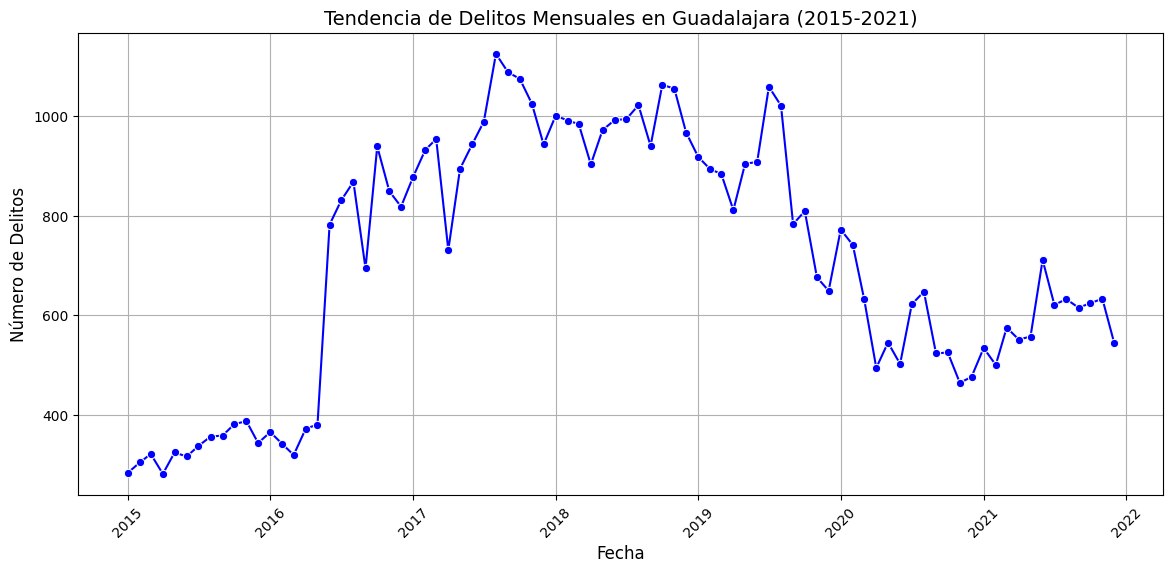

In [42]:
# Convertir de formato ancho a largo (melt)
gdl_fechas = delitos_gdl.melt(id_vars=["Año"], 
                  value_vars=delitos_gdl.columns[9:21], 
                  var_name="Mes", 
                  value_name="Total_Delitos")

# Mapeo de los meses a valores numéricos
meses_orden = {'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4, 'Mayo': 5, 'Junio': 6,
               'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12}
gdl_fechas["Mes"] = gdl_fechas["Mes"].map(meses_orden)

# Crear una columna de fecha en formato YYYY-MM
gdl_fechas["Fecha"] = pd.to_datetime(gdl_fechas["Año"].astype(str) + "-" + gdl_fechas["Mes"].astype(str) + "-01")

# Agrupar por mes y sumar los delitos
gdl_grouped = gdl_fechas.groupby("Fecha")["Total_Delitos"].sum().reset_index()

# raficar la evolución de delitos a lo largo del tiempo
plt.figure(figsize=(14, 6))
sns.lineplot(data=gdl_grouped, x="Fecha", y="Total_Delitos", marker="o", color="b")

# Personalización de la gráfica
plt.title("Tendencia de Delitos Mensuales en Guadalajara (2015-2021)", fontsize=14)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Número de Delitos", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [43]:
from statsmodels.tsa.arima.model import ARIMA

# Crear la serie temporal
#gdl_fechas = gdl_fechas.to_frame().reset_index()
#gdl_fechas.reset_index(inplace=True)
#gdl_fechas.columns = ["Fecha", "Total_Delitos"]
gdl_fechas = gdl_fechas.groupby("Fecha", as_index=False)["Total_Delitos"].sum()
gdl_fechas["Total_Delitos"] = pd.to_numeric(gdl_fechas["Total_Delitos"], errors='coerce')
gdl_fechas["Fecha"] = pd.to_datetime(gdl_fechas["Fecha"])

# Ajustar el modelo ARIMA
gdl_fechas.set_index("Fecha", inplace=True)
modelo = ARIMA(gdl_fechas, order=(2,1,2))  # Ajusta los parámetros según el análisis ACF/PACF
modelo_fit = modelo.fit()

# Hacer predicciones para 2022
gdl_2022 = modelo_fit.forecast(steps=12)  # 12 meses de 2022

# Crear DataFrame de predicciones
fechas_pred = pd.date_range(start="2022-01-01", periods=12, freq='MS')
gdl_pred = pd.DataFrame({"Fecha": fechas_pred, "Total_Delitos": gdl_2022})
gdl_pred["Fuente"] = "Predicción 2022"


d:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


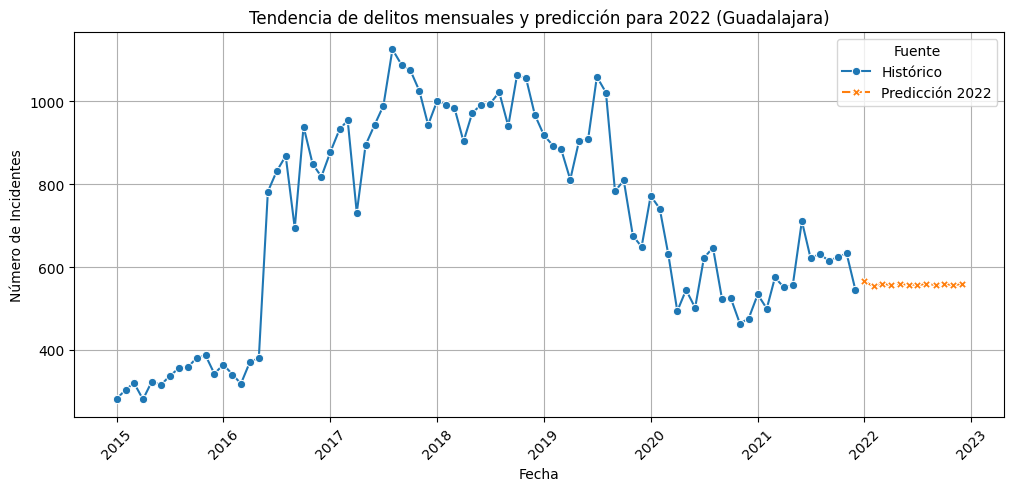

In [44]:
# Unir datos históricos y predicciones
# Restablecer el índice para convertir "Fecha" en una columna normal
gdl_fechas = gdl_fechas.reset_index()

# Agregar la columna "Fuente"
gdl_fechas["Fuente"] = "Histórico"

# Ahora la concatenación debería funcionar
gdl_final = pd.concat([gdl_fechas[["Fecha", "Total_Delitos", "Fuente"]], gdl_pred])
# Graficar
plt.figure(figsize=(12,5))
sns.lineplot(data=gdl_final, x="Fecha", y="Total_Delitos", hue="Fuente", style="Fuente", markers=True)
plt.xticks(rotation=45)
plt.title('Tendencia de delitos mensuales y predicción para 2022 (Guadalajara)')
plt.ylabel('Número de Incidentes')
plt.grid(True)
plt.show()

In [49]:
# Agrupar delitos por estado y año
delitos_estados = delitos_autos.groupby(["Entidad", "Año"])[delitos_autos.columns[9:21]].sum().reset_index()

# Calcular el total de delitos por estado y año
delitos_estados["Total_Delitos"] = delitos_estados.iloc[:, 2:].sum(axis=1)

# Crear un DataFrame con los estados y su tasa de variación en delitos
delitos_variacion = delitos_estados.pivot(index="Entidad", columns="Año", values="Total_Delitos")

# Calcular el porcentaje de variación entre 2015 y 2021
delitos_variacion["Variación (%)"] = ((delitos_variacion[2021] - delitos_variacion[2015]) / delitos_variacion[2015]) * 100

# Ordenar los estados con mayor aumento y mayor disminución de delitos
delitos_variacion_sorted = delitos_variacion.sort_values(by="Variación (%)", ascending=False)

# Mostrar los 5 estados con mayor aumento
print("Estados con mayor aumento en delitos:")
print(delitos_variacion_sorted.head(5))

# Mostrar los 5 estados con mayor disminución
print("\nEstados con mayor disminución en delitos:")
print(delitos_variacion_sorted.tail(5))

Estados con mayor aumento en delitos:
Año              2015  2016  2017  2018  2019  2020  2021  Variación (%)
Entidad                                                                 
Oaxaca            784  4856  5137  5062  5170  4252  4261     443.494898
Quintana Roo     1045  1161  2777  2771  3794  3554  4193     301.244019
San Luis Potosí  1670  2623  3687  6048  7272  5662  5850     250.299401
Colima           1001  1602  2168  1984  1846  1714  2134     113.186813
Campeche          487   908   648   588   764   515   823      68.993840

Estados con mayor disminución en delitos:
Año                   2015  2016  2017  2018  2019  2020  2021  Variación (%)
Entidad                                                                      
Morelos               8334  7460  6724  6574  6083  5784  5903     -29.169666
Coahuila de Zaragoza  2739  2072  2439  2283  1835  1444  1517     -44.614823
Guerrero              5186  5201  5548  4919  4184  2546  2741     -47.146163
Tamaulipas        